In [175]:
import gym
from gym import spaces
import numpy as np
from numpy.random import randint
import networkx as nx


from qutip import *
from IPython.display import Image
from qutip.qip.operations import *
from qutip.qip.circuit import * 
from qutip.qip.device import Processor
from qutip.qip.device import CircularSpinChain, LinearSpinChain
from qutip.qip.noise import RandomNoise
from qutip.operators import sigmaz, sigmay, sigmax, destroy
from qutip.states import basis
from qutip.metrics import fidelity
from qutip.qip.operations import rx, ry, rz, hadamard_transform


import copy
import CircuitUtils as cu
import CircutEmbedding as ce



In [167]:
class QubitHardwareEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    movements = ['up', 'down', 'left', 'right']
    
    def __init__(self, height_grid, width, width_circuit):    
        super(QubitHardwareEnv, self).__init__()
        self.width_of_circuit = width_of_circuit
        self.height_grid = height_grid
        self.width_grid = width_grid
        #keep track of how many steps have been taken in an episode
        self.step = 0
        harware = nx.generators.lattice.grid_2d_graph(self.height, self.width, create_using = nx.DiGraph)
        #hardware = ce.relabel(hardware)
        self.circuit  = nx.DiGraph()
        self.circuit.add_nodes_from(grid)
        self.num_qubits  = self.circuit.number_of_nodes()
        self.gates_list = []
        #adj = {node:list(edges) for node,edges in dict(grid.adj).items()}
    
    

        # Define action and observation space

        #Will need the following actions:
        #Apply a hadamard, apply a swap, apply a cnot
        #When it applys a CNOT or SWAP it needs to identify which qubits it 
        #can apply gates to from current possition and choose one
        #Will have a pointer that applies a gate to the pointers location
        #Instead of allowing the pointer to teleport anywhere it wants restrict it to moving one space in a direction from its current position
        gates = 3 #Hadamard, CNOT, SWAP

        self.action_space = spaces.Tuple([spaces.Discrete(len(movements)), #spaces.Box(low=np.array([0, 0]), high=np.array([vert_len_grid, horizon_len_grid]),dtype=np.int16),
                                         spaces.Discrete(gates)])
        # Example for using image as input:
        self.observation_space = spaces.Box(low=0, high=1, shape = (num_qubits,num_qubits) ,dtype=np.float16)
        
    def step(self, action):
        direction, gate = action
        self.previous_postion = copy(self.grid_pos)
        self.used_points.append(self.previous_postion)
        x,y = self._move(direction)
        done = False
        
        if x > self.width_grid or x < 0:
            done = True
            reward = 0
        if y > self.height_grid or y < 0:
            done = True
            reward = 0      
        
        if not done:
            self.grid_pos = x,y   
            if (self.grid_pos in set(self.used_points)):
                done = True
                reward = 0
            elif step == 0:
                if gate == 0:
                    state = self.apply_gate(gate)
                    reward = self.avg_fidelity(previous_position,self.num_cnots)
                    step += 1
                elif gate > 0:
                    done = True
                    reward = -1
            elif step > 0:
                if gate == 0:
                    done = True
                    reward = -1
                elif gate > 0:
                    if gate == 1:
                        num_cnots += 1
                    state = self.apply_gate(gate)
                    reward = self.avg_fidelity(current_position,self.num_cnots)
                    step += 1
        if num_cnots == self.width_circuit:
            done = True
            reward = fidelity(self.circuit)
        return state, reward, done, {}
    

    def move(self, move):
        x, y = self.grid_pos
        if movements[direction] == 'up':
            y += 1
        elif movements[direction] == 'down':
            y -= 1
        elif movements[direction] == 'left':
            x -= 1
        else:
            x += 1
        return x,y
    
    def apply_gate(self, gate):
        if gate > 0:
            self.circuit.add_edge(self.previous_position, self.grid_pos)
        
        
    def reset(self):
        self.used_points = []
        self.num_cnots = 0
        self.step = 0
        self.grid_pos = (np.randint(0, self.width_grid),np.randint(0, self.height_grid))
        self.circuit = nx.DiGraph()
        self.circuit.add_nodes_from(grid)
        self.gates_list = []
        return nx.convert_matrix.to_numpy_matrix(self.circuit)
    def render(self, mode='human', close=False):
        pass
    # Render the environment to the screen
    

In [157]:
observation_space = spaces.Box(low=0, high=1, shape = (9,9) ,dtype=np.float16)

In [158]:
observation_space.sample()

array([[0.7954 , 0.595  , 0.756  , 0.7847 , 0.6284 , 0.06775, 0.91   ,
        0.3516 , 0.0968 ],
       [0.1087 , 0.727  , 0.8994 , 0.1626 , 0.6387 , 0.419  , 0.9263 ,
        0.1726 , 0.4504 ],
       [0.2333 , 0.1367 , 0.2455 , 0.0549 , 0.641  , 0.65   , 0.1398 ,
        0.8926 , 0.7925 ],
       [0.5615 , 0.0884 , 0.5557 , 0.918  , 0.3289 , 0.398  , 0.3203 ,
        0.08844, 0.7817 ],
       [0.04456, 0.1015 , 0.03864, 0.8975 , 0.9014 , 0.2283 , 0.03235,
        0.4683 , 0.4377 ],
       [0.2664 , 0.2625 , 0.711  , 0.3118 , 0.908  , 0.8223 , 0.9414 ,
        0.3262 , 0.2915 ],
       [0.1085 , 0.7153 , 0.8086 , 0.6045 , 0.3765 , 0.576  , 0.8794 ,
        0.787  , 0.3254 ],
       [0.954  , 0.5806 , 0.688  , 0.899  , 0.1284 , 0.1104 , 0.6743 ,
        0.435  , 0.359  ],
       [0.0705 , 0.7876 , 0.5596 , 0.6772 , 0.674  , 0.2206 , 0.1907 ,
        0.0952 , 0.937  ]], dtype=float16)

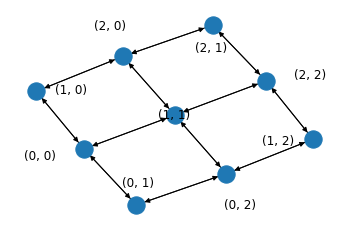

In [181]:
grid = nx.generators.lattice.grid_2d_graph(3,3, create_using = nx.DiGraph)
#grid = ce.relabel_grid(grid)
adj_dict = {node:list(edges) for node,edges in dict(grid.adj).items()}
#circuit = nx.DiGraph().add_nodes_from(grid)   
nx.draw_networkx_labels(grid, pos=nx.spring_layout(grid))
#nx.draw(circuit)
nx.draw(grid)
    

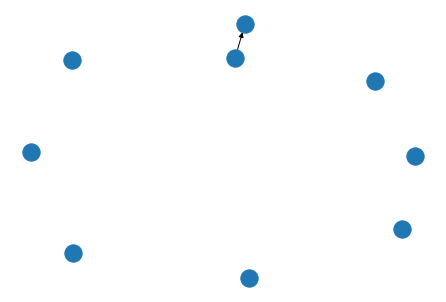

In [185]:
circuit = nx.MultiDiGraph()
circuit.add_nodes_from(grid)
circuit.add_edge((0,0),(0,0), gate = "H")
circuit.add_edge((0,0),(0,1), gate = "CNOT")
#circuit.add_edge(1,0)
nx.draw(circuit)

In [188]:
arr = nx.convert_matrix.to_numpy_array(circuit)
circuit.number_of_nodes()

9

In [189]:
print(arr)

[[1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [190]:
arr

array([[1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])